# Using Correlation to Cluster

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform
import networkx as nx
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import math

In [38]:
online_retail_df = pd.read_json('../dataset/online_retail.json')

In [39]:
online_retail_df = online_retail_df.rename(columns={"FuzzedDescription": "Description"})

In [40]:
units_sold_pivoted_df = (
    online_retail_df.pivot(
        index='Date', columns='Description', values='UnitsSold')
    .fillna(0)
)

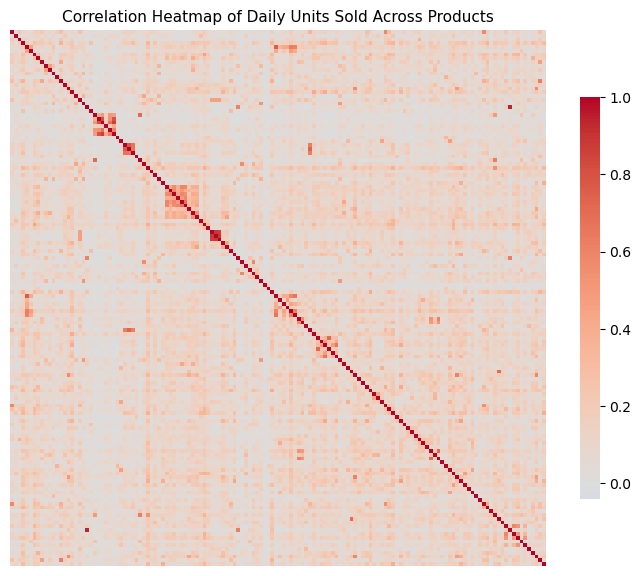

In [41]:
corr_matrix = units_sold_pivoted_df.corr()

plt.figure(figsize=(7, 7))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    square=True,
    cbar_kws={'shrink': 0.6},
    xticklabels=False,
    yticklabels=False
)
plt.xlabel('')
plt.ylabel('')
plt.title('Correlation Heatmap of Daily Units Sold Across Products', fontsize=11)
plt.tight_layout()
plt.show()

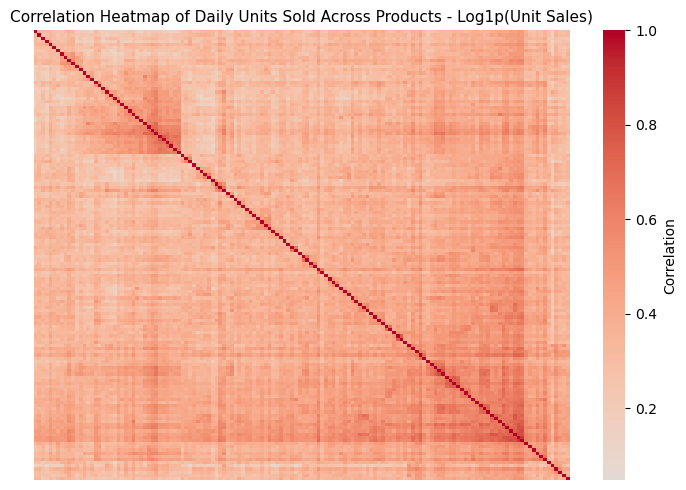

In [42]:
# Log transform to reduce skew
log_product_matrix = np.log1p(units_sold_pivoted_df)

# Correlation matrix
corr_matrix = log_product_matrix.corr()

# Hierarchical clustering to reorder rows/columns
linkage_matrix = linkage(squareform(1 - corr_matrix), method='average')
ordered_idx = leaves_list(linkage_matrix)
ordered_corr = corr_matrix.iloc[ordered_idx, ordered_idx]

# Clean heatmap without dendrogram
plt.figure(figsize=(7,5))
sns.heatmap(
    ordered_corr,
    cmap='coolwarm',
    center=0,
    xticklabels=False,
    yticklabels=False,
    cbar_kws={'label': 'Correlation'}
)
plt.title('Correlation Heatmap of Daily Units Sold Across Products - Log1p(Unit Sales)', fontsize=11)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [43]:
corr_matrix.index.name = "Product A"
corr_matrix.columns.name = "Product B"

# Mask lower triangle and diagonal
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Stack and filter
high_corr_pairs = upper.stack().reset_index()
high_corr_pairs.columns = ['Product A', 'Product B', 'Correlation']

# Filter for strong correlations
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > 0.6]

# Sort by strength
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

# Show top results
high_corr_pairs


,Product A,Product B,Correlation
4537,hanging heart zinc tlight holder,white hanging heart tlight holder,0.890499
5992,love building block word,white hanging heart tlight holder,0.817812
6356,lunchbag spaceboy design,lunchbag suki design,0.816434
4483,hanging heart zinc tlight holder,pack of 72 retro spot cake cases,0.812607
7786,pack of 72 retro spot cake cases,white hanging heart tlight holder,0.809994
...,...,...,...
4509,hanging heart zinc tlight holder,rex cashcarry jumbo shopper,0.600633
6267,lunch bag cars blue,woodland charlotte bag,0.600592
8467,plasters in tin vintage paisley,wooden school colouring set,0.600485
1092,assorted colour bird ornament,wooden frame antique white,0.600135


In [44]:
# Create graph: nodes = products, edges = strong correlations
G = nx.Graph()

# Add edges from high_corr_pairs (already filtered to r > 0.6)
for _, row in high_corr_pairs.iterrows():
    G.add_edge(row['Product A'], row['Product B'], weight=row['Correlation'])

# Find connected components (clusters)
clusters = list(nx.connected_components(G))

count = 0

# Print cluster sizes
for i, cluster in enumerate(clusters, 1):
    print(f"Cluster {i} ({len(cluster)} products): {sorted(cluster)}")
    count = count + len(cluster)

print("Number of products that were clustered:", count)

Cluster 1 (76 products): ['6 ribbons rustic charm', '60 teatime fairy cake cases', '72 sweetheart fairy cake cases', 'antique silver tea glass etched', 'assorted colour bird ornament', 'bag 500g swirly marbles', 'bathroom metal sign', 'blue harmonica in box', 'charlotte bag suki design', 'colour glass tlight holder hanging', 'cook with wine metal sign', 'gin tonic diet metal sign', 'hanging heart zinc tlight holder', 'hanging metal star lantern', 'jumbo bag baroque black white', 'jumbo bag pink vintage paisley', 'jumbo bag scandinavian paisley', 'jumbo bag spaceboy design', 'jumbo bag strawberry', 'jumbo bag toys', 'jumbo shopper vintage red paisley', 'jumbo storage bag skulls', 'love building block word', 'lovebird hanging decoration white', 'lunch bag black skull', 'lunch bag cars blue', 'lunch bag woodland', 'lunchbag spaceboy design', 'lunchbag suki design', 'lunchbox i love london', 'natural slate heart chalkboard', 'pack of 12 woodland tissues', 'pack of 6 birdy gift tags', 'pack

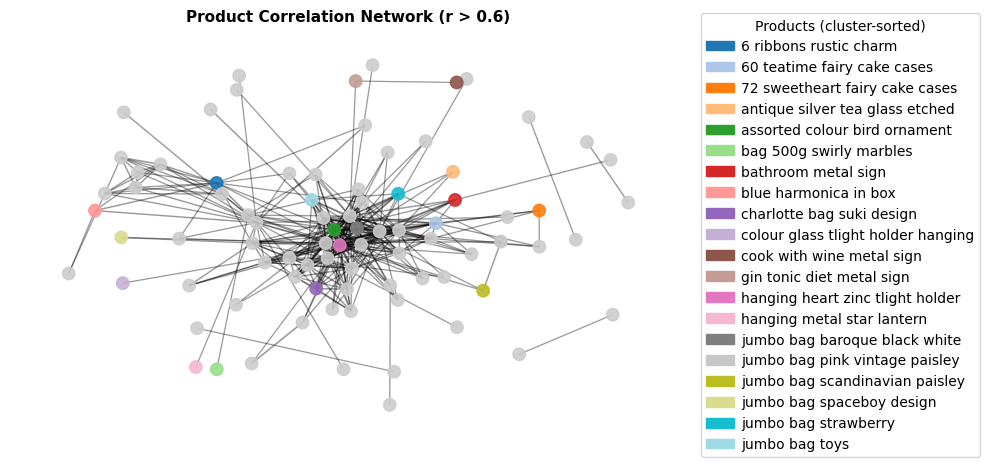

In [45]:
# Extract clusters
clusters = list(nx.connected_components(G))

# Flatten product list (product, cluster_id), sorted by cluster then name
clustered_products = []
for cluster_id, cluster in enumerate(clusters):
    for product in sorted(cluster):
        clustered_products.append((product, cluster_id))

# Limit to top N products
N = 20
top_products = clustered_products[:N]

# Assign distinct colors
tab20 = plt.get_cmap('tab20').colors
product_colors = {
    product: tab20[i % len(tab20)] for i, (product, _) in enumerate(top_products)
}
default_color = (0.8, 0.8, 0.8)

# Compute layout
pos = nx.spring_layout(G, k=0.5, seed=42)

# Draw graph
plt.figure(figsize=(10, 5))
node_colors = [product_colors.get(node, default_color) for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=80, alpha=0.9)
nx.draw_networkx_edges(
    G, pos,
    edgelist=G.edges(),
    width=[G[u][v]['weight'] * 1.5 for u, v in G.edges()],
    alpha=0.4
)

# Build legend entries, adding separator between cluster transitions
legend_handles = []
last_cluster = None
for product, cluster_id in top_products:
    if last_cluster is not None and cluster_id != last_cluster:
        # Add a separator (a transparent patch with a line as the label)
        legend_handles.append(
            mpatches.Patch(color='none', label='──────────')  # separator line
        )
    legend_handles.append(
        mpatches.Patch(color=product_colors[product], label=product)
    )
    last_cluster = cluster_id

plt.legend(
    handles=legend_handles,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    title='Products (cluster-sorted)',
    handletextpad=0.5,
    borderaxespad=1
)

plt.title("Product Correlation Network (r > 0.6)", fontsize=11, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [46]:
def human_format(num):
  """Convert a number to a human readable version, e.g. 10M for 10,000,000."""
  if num == 0:
    return '0'
  letters = ["", "K", "M", "B", "T"]
  scale = math.floor(math.log10(abs(num)) / 3)
  # Convert to string: truncate to scale, remove trailing zeros and decimal points
  num = float('{:.3g}'.format(num)) / 10**(3*scale)
  num_str = str(num).rstrip('0').rstrip('.')
  # Append scale letter
  return f'{num_str}{letters[int(scale)]}'

def mpl_human_format(x, pos):
  """Formatter for matplotlib to use human_format."""
  if pos is not None:
    return human_format(x)
  return ''

def make_axes_human_readable(ax, axis="y"):
  """Apply human readable formatting to the specified axis of a matplotlib axes object."""
  if axis.lower() == 'x':
    axisvar = ax.xaxis
  elif axis.lower() == 'y':
    axisvar = ax.yaxis
  else:
    raise ValueError("Must specify axis as either 'x' or 'y'")

  axisvar.set_major_formatter(ticker.FuncFormatter(mpl_human_format))
  return ax

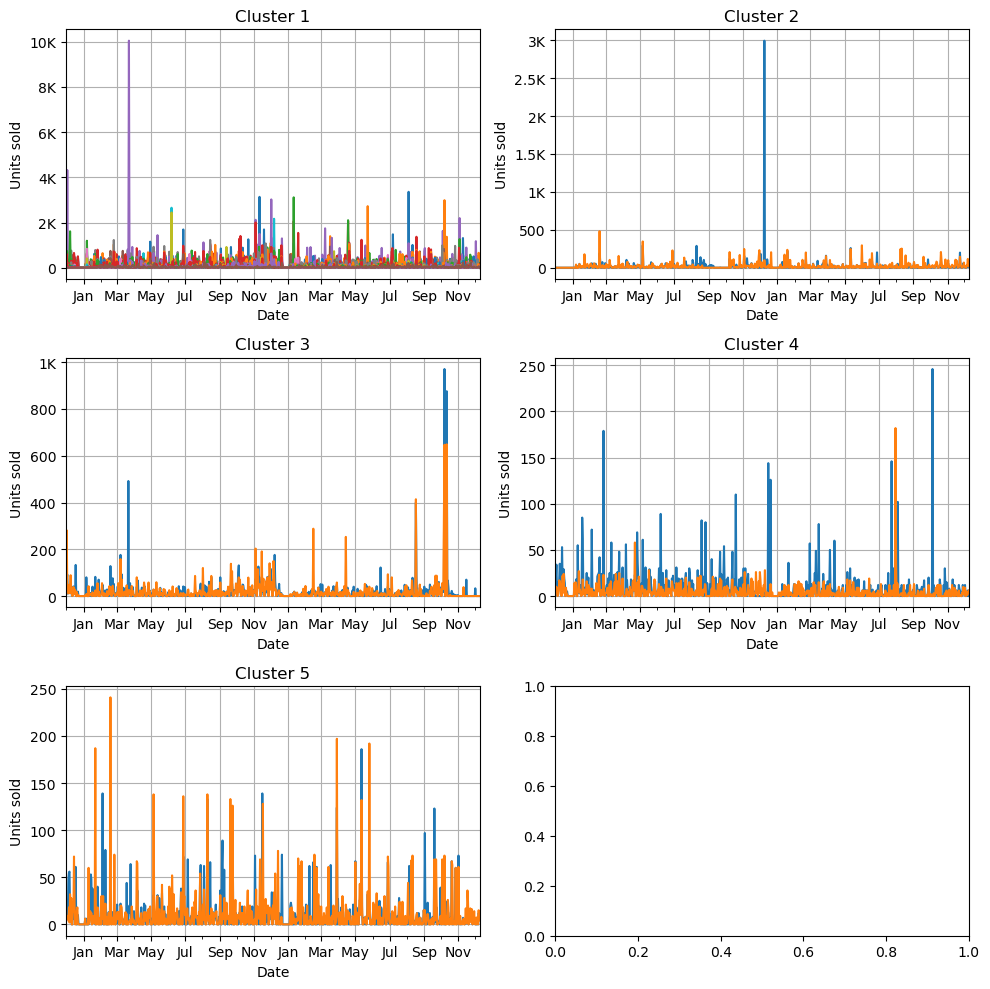

In [47]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

for i, (ax, cluster) in enumerate(zip(axs.flatten(), clusters), start=1):
    cluster = list(cluster)
    units_sold_pivoted_df[cluster].plot(ax=ax)

    ax.set_title(f'Cluster {i}')
    ax.set_xlabel("Date")
    ax.set_ylabel('Units sold')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # e.g., 'Jan 2010'
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # every 2 months
    ax.tick_params(axis='x', rotation=0)
    ax.legend().remove()
    ax.grid()
    make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

In [48]:
corr_matrix.index.name = "Product A"
corr_matrix.columns.name = "Product B"

# Mask lower triangle and diagonal
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Stack and filter
high_corr_pairs = upper.stack().reset_index()
high_corr_pairs.columns = ['Product A', 'Product B', 'Correlation']

# Filter for strong correlations
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > 0.5]

# Sort by strength
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

# Create graph: nodes = products, edges = strong correlations
G = nx.Graph()

# Add edges from high_corr_pairs (already filtered to r > 0.8)
for _, row in high_corr_pairs.iterrows():
    G.add_edge(row['Product A'], row['Product B'], weight=row['Correlation'])

# Find connected components (clusters)
clusters = list(nx.connected_components(G))

# Print cluster sizes
for i, cluster in enumerate(clusters, 1):
    print(f"Cluster {i} ({len(cluster)} products): {sorted(cluster)}")

Cluster 1 (140 products): ['12 pencils small tube red spotty', '12 pencils tall tube posy', '12 pencils tall tube woodland', '6 ribbons rustic charm', '60 teatime fairy cake cases', '72 sweetheart fairy cake cases', 'antique silver tea glass etched', 'assorted colour bird ornament', 'bag 500g swirly marbles', 'baking set 9 piece retrospot', 'baking set spaceboy design', 'bathroom metal sign', 'blue happy birthday bunting', 'blue harmonica in box', 'box of 24 cocktail parasols', 'charlotte bag suki design', 'childs apron spaceboy design', 'chocolate this way metal sign', 'colour glass tlight holder hanging', 'cook with wine metal sign', 'cream heart card holder', 'door mat fairy cake', 'door mat new england', 'door mat spotty home sweet home', 'door mat union flag', 'doormat hearts', 'edwardian parasol natural', 'fancy font birthday card', 'feltcraft 6 flower friends', 'feltcraft butterfly hearts', 'feltcraft cushion owl', 'four hook white lovebirds', 'gin tonic diet metal sign', 'hand 